In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import loguniform, uniform
from matplotlib.pyplot import cm
import re
import EzTao.src.eztao
from EzTao.src.eztao.carma import DHO_term, CARMA_term
from EzTao.src.eztao.ts import gpSimFull, gpSimByTime, addNoise
from EzTao.src.eztao.ts.carma_fit import sample_carma

## Plotting CARMA PSD from a range of alpha,beta and sigma values

In [16]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

def search_elements_with_pattern(arr, pattern):
    '''
    Just a function facilitate a filtering process
    '''
    matched_elements = []
    for element in arr:
        if re.search(pattern, element):
            matched_elements.append(element)
    return matched_elements

def CARMA_PSD_pq(params, freq):
    '''
    Function to calculate the PSD of a CARMA processing the equation in Kelly et. al 2014
    Parameters:
    --------------------------------------------------------------------------------------
    params  :  dict of log_alpha, log_beta, log_sigma values (not including \alpha_p or \beta_o, as they are equal 1) 
    freq    :  freq in which PSD is calculated.
    
    '''
    
    key_list = np.array(list(params.keys()))

    alpha_keys = search_elements_with_pattern(key_list, 'alpha')
    beta_keys = search_elements_with_pattern(key_list, 'beta')
    sigma = np.exp(params[search_elements_with_pattern(key_list, 'sigma')[0]])

    alpha_vals = []
    for key in alpha_keys:
        alpha_vals.append(params[key])
    alpha_vals =list(np.exp(np.array(alpha_vals)))
    
    alpha_vals.append(1)
    
    beta_vals = [1]
    for key in beta_keys:
        beta_vals.append(params[key])
        
    beta_vals = list(np.exp(np.array(beta_vals)))
    p = len(alpha_keys)
    q = len(beta_keys)
    #print(p,q)
    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(2*np.pi*1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(2*np.pi*1j* freq)**u )

    PSD = sigma**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

def param_gen(p, q, alpha_range = [-7, 2.5], beta_range = [-7, 2.5], sigma_range = [-3, 5.3]):
    '''
    Function to generate log_alpha, log_beta, log_sigma values (not including \alpha_p or \beta_o, as they are equal 1) 
    The values are genereted from a uniform prior given the ranges for each parameter.
    
    Parameter:
    --------------------------------------------------------------------------------------------------------------
    p, q        : Order of AR and MA part of CARMA.
    alpha_range
    beta_range     : Ranges for log_alpha, log_beta and log_sigma of lorentzians
    sigma_range    

    Returns:
    --------------------------------------------------------------------------------------------------------------
    A dict with p number of log_alpha values, q number of log_beta values and log_sigma

    '''
    
    param_dict = {}
    for i in range(p):
        param_dict['log_alpha'+str(i)] = uniform.rvs(alpha_range[0], alpha_range[1] - alpha_range[0])
    
    for i in range(q):
        param_dict['log_beta'+str(i+1)] = uniform.rvs(beta_range[0], beta_range[1] - beta_range[0])    
        
    param_dict['log_sigma'] = uniform.rvs(sigma_range[0], sigma_range[1] -sigma_range[0])
    
    return param_dict

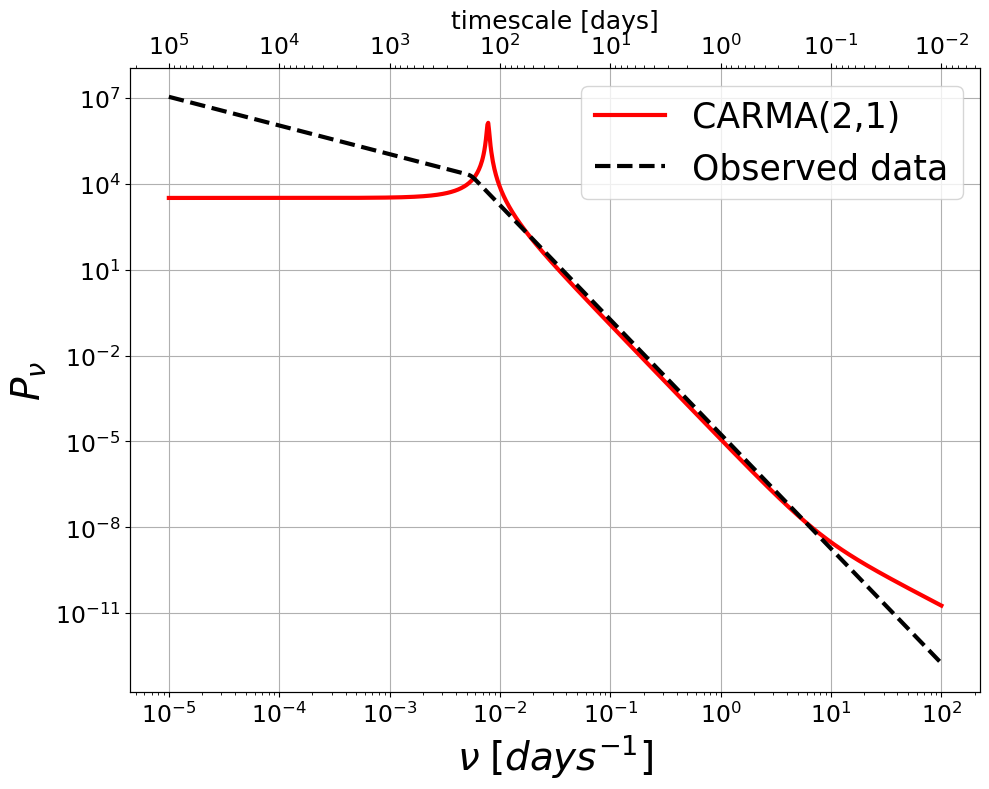

In [46]:
freq = np.logspace(-5,2,1000)
spectrum_OBS1 = bend_pl(freq, 20000,  2/365,  -1,-4,10)
p,q = 2,1 # Order of AR and MA that needs to simulated.
psd = []
psd_data = {'freq' : [], 'psd' : []}

for i in range(1): #  plots 100 PSD of CARMA(p,q) using alpha, beta, and sigma drawn from randomly drawn values
    PSD = CARMA_PSD_pq(param_gen(p,q , alpha_range=[-6.1,-6], beta_range=[-3,-2.9],sigma_range = [-3, -2.9]), freq)
    psd_data['freq'] = np.concatenate([psd_data['freq'], freq])
    psd.append(PSD)
    psd_data['psd'] =np.concatenate([psd_data['psd'], PSD])
    # plt.plot(freq , PSD,
    #             'k-', alpha=0.2)

spectrum_CARMA21 =  np.median(psd, axis=0)




fig, ax = plt.subplots(1,1, figsize=[10,8])
#lc = self.sim.simulate(spectrum)
#plt.plot(lc.time/365, lc.counts, 'g')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_title('Power spectrum', fontsize=16)
ax.set_ylabel(r'$P_{\nu}$', fontsize=28)
ax.set_xlabel(r'$\nu\;[days^{-1}]$', fontsize=28)
ax.grid()
#ax.set_ylim(bottom=10**-9 ,top = 10**5)
ax.tick_params(labelsize=17)
ax_top = ax.twiny()  
ax_top.set_xlabel('timescale [days]', fontsize = 18) 
ax_top.plot(1/freq, spectrum_CARMA21,'r-', lw=3, alpha=0.0)
ax_top.set_xscale('log')
ax_top.set_yscale('log')


ax.plot(freq, spectrum_CARMA21,'-', color= 'red', lw=3, label='CARMA(2,1)')
ax.plot(freq, spectrum_OBS1,'k--', lw=3, label = 'Observed data')

ax_top.tick_params(axis='x', labelsize=17)
ax_top.invert_xaxis()

ax.legend(fontsize=25)
plt.tight_layout()
plt.savefig('plots/NAC/CARMA21_PSD_opaque.png', transparent = False)
plt.show()

## Plotting sum of lorentzians

In [35]:
def param_gen_alpha_beta(p, q, alpha_range = [-7, 7], beta_range = [-7, 7], sigma_range = [-0, 0.01]):
    '''
    Function to generate log_alpha, log_beta and log_sigma parameters given p and q values
    This function is same as used before, but also contains the log of \alpha_p and \beta_0 (=1)
    
    '''
    param_dict = {}
    for i in range(p):
        param_dict['log_alpha'+str(i)] = uniform.rvs(alpha_range[0], alpha_range[1] - alpha_range[0])
    
    #param_dict['log_alpha'+str(p)] = 0
    #param_dict['log_beta0'] = 0
    for i in range(q):
        param_dict['log_beta'+str(i+1)] = uniform.rvs(beta_range[0], beta_range[1] - beta_range[0])    
        
    param_dict['log_sigma'] = uniform.rvs(sigma_range[0], sigma_range[1] -sigma_range[0])
    
    return param_dict

def search_elements_with_pattern(arr, pattern):
    '''
    Just a function facilitate a filtering process below
    '''
    matched_elements = []
    for element in arr:
        if re.search(pattern, element):
            matched_elements.append(element)
    return matched_elements


def return_alpha_vals(par_dict):
    '''
    function to return alpha values from a dict of log_alpha, log_beta, and log_sigma
    
    returned alpha is order as \alpha_p, \alpha_{p-1}.... \alpha_0, where \alpha_p = 1
    '''
    alpha_keys = search_elements_with_pattern(par_dict.keys(), 'alpha')

    alpha_vals = []
    for key in alpha_keys:
        alpha_vals.append(par_dict[key])
    alpha_vals =list(np.exp(np.array(alpha_vals)))
    alpha_vals.reverse()
    return alpha_vals

def return_beta_vals(par_dict):
    '''
    function to return alpha values from a dict of log_alpha, log_beta, and log_sigma
    
    returned beta is order as \beta_0, \beta_{1}.... \beta_q, where \beta_0 = 1
    '''
    beta_keys = search_elements_with_pattern(par_dict.keys(), 'beta')

    beta_vals = []
    for key in beta_keys:
        beta_vals.append(par_dict[key])
    beta_vals =list(np.exp(np.array(beta_vals)))
    return beta_vals


def create_complex_conjugates(real_parts, imag_parts):
    '''
    Function to create complex conjugates given real and imaginary part array
    '''
    complex_pairs = []
    for real, imag in zip(real_parts, imag_parts):
        z = complex(real, imag)
        z_conjugate = z.conjugate()
        complex_pairs.append((z, z_conjugate))
    return complex_pairs

def extract_real_imaginary(complex_numbers):
    '''
    Function to return real and imaginary parts of an array of complex numbers
    '''
    real_parts = []
    imaginary_parts = []
    for z in complex_numbers:
        real_parts.append(z.real)
        imaginary_parts.append(z.imag)
    return real_parts, imaginary_parts


def param_gen_lorentzian(p, q, center_range = [-7, 2.5], width_range = [-7, 2.5], amp_range = [-1, 10], from_alpha = False, alpha_vals = []):
    '''
    Function to generate parameters of a lorentizian. 
    
    Parameters:
    ------------------------------------------------------------------------------
    p               : order of AR part (Number of lorentzians in the CARMA)
    q               : order of MA part (Not used in the parameter generation)
    center_range
    width_range     : Ranges for center, width and amplitude of lorentzians
    amp_range       
    from_alpha      : If true, used the alpha_vals provided, to calculate the complex roots.
                        Else, generate random values from the ranges above.
    alpha_vals      : when from_alpha is True, complex_roots are calculated using this values
    
    Returns:
    ------------------------------------------------------------------------------
    a stacked array of p sets of randomly generated parameters for a p-order CARMA process. 
    Each set of parameters consists of three values ordered as (center, width, amplitude).
    
    '''
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # I based this on the CARMA notes, speccifically the results of the conversion between roots to lorentzian parameters.
    # Points considered while making the code are:
    #     > the roots are complex conjugates or real(when p is odd)
    #     > imaginary parts of complex roots are equal to center of lorentzian(didnot divide  them by 2*pi as it is just a factor)
    #     > real parts of complex roots are equal to widths of lorentzian(didnot divide  them by 2*pi as it is just a factor)
    #     > When p is even, the roots are all complex conjugates of each other
    #         > p/2 loretzians centered  at rho_{0,l}
    #         > p/2 loretzians centered  at -rho_{0,l}
    #     > When p is odd, the roots are all complex conjugates of each other, except for the last root, which is real
    #         > (p-1)/2 loretzians centered  at rho_{0,l}
    #         > (p-1)/2 loretzians centered  at -rho_{0,l}
    #         > one loretzian centered  at 0    
    #     > amplitudes are not related to frequency and just real numbers
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    if not from_alpha:
        # this if condition generates random number for the paramters center and width, for the loretzian
        
        re_val = []         # list to store real parts
        im_val = []         # list to store imaginary parts
        
        for i in range(int(p/2)):
            re_val.append(uniform.rvs(width_range[0], width_range[1] - width_range[0]))
            im_val.append(uniform.rvs(center_range[0], center_range[1] - center_range[0]))
        
        # make the complex comjugates from the p/2 complex numbers generated
        complex_roots = list(np.array(create_complex_conjugates(re_val, im_val)).flatten())
        
        # If the p is odd, add a real root to the set of generated roots.
        if p%2 !=0:
            complex_roots.append(complex(uniform.rvs(width_range[0], width_range[1] - width_range[0]),0))
            
            
    else:
        # This if condition uses the given alpha values to calculate the roots to the AR polynomial, which is then used for 
        # width and center_vals
        complex_roots = np.roots(alpha_vals)        
        
        
    # Extract the real and imaginary parts, which are width and center values respectively.
    width_val, center_val = extract_real_imaginary(complex_roots) 
    
    # Amplitude values generation
    amp_val = uniform.rvs(amp_range[0],amp_range[1]-amp_range[0], size = p)
    
    return_array = []
    for center, width, amp in zip(center_val, width_val, amp_val):
        return_array.append((center, width, amp))
    
    return return_array


def lorentzian(x, params):
    """
    Returns Lorentzian function at x.
    """
    center, width, amplitude = params
    return amplitude / (width**2 + ((x - center))**2)

def sum_of_lorentzians(x, n, params_list):
    """
    Returns sum of n Lorentzian functions.
    """
    result = np.zeros_like(x)
    for params in params_list[:n]:
        result += lorentzian(x, params)
    return result

### test

3762
(3.649676092180048, -1.210969184862169, 1.0529164813409055)
(-3.649676092180048, -1.210969184862169, 6.11848740392109)


NameError: name 'CARMA_PSD_pq' is not defined

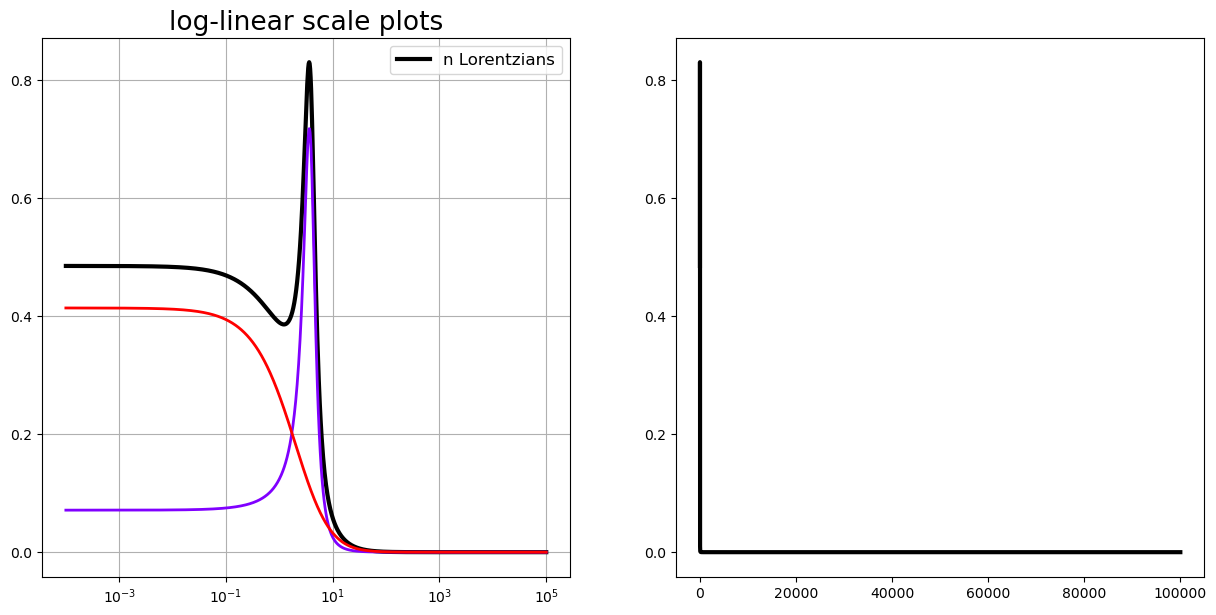

In [4]:
if True:
    x_values = np.logspace(-4, 5, 1000)

    rand =np.random.randint(10000)
    print(rand)
    np.random.seed(rand)

    p = 2  # order of AR process or number of lorentzians
    color = cm.rainbow(np.linspace(0, 1, p))

    alpha_beta_vals = param_gen_alpha_beta(p,1)
    params_list = param_gen_lorentzian(p, 1, from_alpha=True, alpha_vals= return_alpha_vals(alpha_beta_vals), )
    sum_of_lorentzians_values = sum_of_lorentzians(x_values, len(params_list), params_list)

    # print the generated paramters
    for val in params_list:
        print(val)


    fig = plt.figure(figsize=[15,7])
    fig.add_subplot(121)
    plt.plot(x_values, sum_of_lorentzians_values, 'k-', lw=3, label = "n Lorentzians")
    for i, val in enumerate(params_list):
        plt.plot(x_values, lorentzian(x_values, val), lw=2, alpha=1, color = color[i])
    plt.xscale('log')
    plt.gca().set_title("log-linear scale plots", fontsize=19)
    plt.gca().grid(True)
    plt.gca().legend(fontsize=12)



    fig.add_subplot(122)
    plt.plot(x_values, np.abs(sum_of_lorentzians_values), 'k-', lw=3, label = "n Lorentzians")
    plt.plot(x_values, CARMA_PSD_pq(alpha_beta_vals, x_values), 'k--')

    plt.grid(True)
    for i, val in enumerate(params_list):
        plt.plot(x_values, lorentzian(x_values, val), lw=2, alpha=1, color = color[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Log scale plots", fontsize=19)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

### rest

In [8]:
def CARMA2loretzian(CARMAparams):
    alpha_vals = return_alpha_vals(CARMAparams)
    beta_vals = return_beta_vals(CARMAparams)

    #print("alpha, beta :",alpha_vals, beta_vals)
    complex_roots = np.roots(alpha_vals)  
    print("roots of AR :",complex_roots)
    widths, centers = extract_real_imaginary(complex_roots)
    
    amplitudes = []
    for k in range(len(alpha_vals)-1):
        sum1 = 0
        for l in range(len(beta_vals)):
            sum1=sum1+beta_vals[l]*(complex_roots[k])**l
            
        sum2 = 0
        for l in range(len(beta_vals)):
            sum2=sum2+beta_vals[l]*(-1*complex_roots[k])**l
        
        num = sum1*sum2

        #print("num : ",num)
        
        denom = -2 * np.real(complex_roots[k])
        for l in range(len(alpha_vals)-1):
            if l!=k:
                denom = denom * (complex_roots[l] - complex_roots[k]) * (np.conjugate(complex_roots[l]) + complex_roots[k])
                
        #print("denom :",denom)
        amp_penulti = num/denom
        #print("penultu :",amp_penulti)
        
        amplitudes.append(np.abs(amp_penulti)**2)
    
    return_array = []
    for c, w, a in zip(centers, widths, amplitudes):
        return_array.append((c, w, a))
        
    return return_array

In [9]:
def CARMA_PSD_pq(params, freq):
    '''
    Function to calculate the PSD of a CARMA processing the equation in Kelly et. al 2014
    Parameters:
    --------------------------------------------------------------------------------------
    params  :  dict of log_alpha, log_beta, log_sigma values (not including \alpha_p or \beta_o, as they are equal 1) 
    freq    :  freq in which PSD is calculated.
    
    '''
    
    alpha_vals = return_alpha_vals(params)
    beta_vals = return_beta_vals(params)
    p = len(alpha_vals)-1
    q = len(beta_vals)-1

    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(2*np.pi*1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(2*np.pi*1j* freq)**u )

    PSD = 1**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

In [10]:
def CARMA_ACVF_pq(params, lag, return_coeff=False):
    alpha_vals = return_alpha_vals(params)
    beta_vals = return_beta_vals(params)

    complex_roots = np.roots(alpha_vals)  
    # a_array, b_array = extract_real_imaginary(complex_roots)
    
    #print(complex_roots)
    sum_term = 0
    coeffs = []
    for i in range(len(complex_roots)):
        num_left = 0
        for j,val in enumerate(beta_vals):
            num_left = num_left + beta_vals[j]*complex_roots[i]**j
        
        num_right = 0
        for j,val in enumerate(beta_vals):
            num_right = num_right + beta_vals[j]*(-1*complex_roots[i])**j
        
        numerator = num_left*num_right
        
        denomerator = -2*np.real(complex_roots[i])
        #print(denomerator)
        #print(complex_roots)
        for j in range(len(complex_roots)):
            if i!=j:
                denomerator = denomerator * (complex_roots[j] - complex_roots[i]) * (np.conjugate(complex_roots[j]) + complex_roots[i]) 

        if return_coeff:
            coeffs.append(numerator/denomerator)
        else:
            sum_term = sum_term +  (numerator/denomerator) * np.exp(complex_roots[i] * lag)
    if return_coeff:
        return coeffs
    else:
        return sum_term

In [6]:

# Generate a grid of time lags
t = np.linspace(0, 10, 1000)
dt = t[1] - t[0]
lags = np.arange(len(t)) * dt

# Define the SHO kernel
Q = 1.0 / np.sqrt(2.0)
w0 = 2.0
S0 = 1.0
kernel = terms.SHOTerm(S0=S0, w0=w0, Q=Q)

# Compute the ACVF
omega = 2 * np.pi / lags[1:]  # Convert time lags to frequencies
acvf = kernel.get_value(omega)

# Compute the Power Spectrum directly from the SHO kernel
power_spectrum_direct = kernel.get_psd(omega)

# Compute the Power Spectrum from the ACVF using FFT
psd_from_acvf = np.abs(np.fft.fft(acvf))**2
freq = np.fft.fftfreq(len(lags)-1, d=dt)
psd_from_acvf = psd_from_acvf[freq >= 0]
freq = freq[freq >= 0]

# Normalize the PSD from ACVF to match the direct PSD
psd_from_acvf *= np.trapz(power_spectrum_direct, omega) / np.trapz(psd_from_acvf, freq)

# Plot the ACVF and Power Spectra
plt.figure(figsize=(8, 6))

# Plot PSD from SHO kernel
plt.plot(omega, power_spectrum_direct, label="Direct PSD of SHO kernel", color='r')

# Plot PSD from ACVF
plt.plot(freq, psd_from_acvf, label="PSD from ACVF", color='g')

plt.xlabel(r"Frequencies $\omega$")
plt.ylabel("Power Spectrum")
plt.title("Power Spectra of SHO Kernel")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'terms' is not defined

In [11]:
def CARMA_PSD_pq(params, freq):
    '''
    Function to calculate the PSD of a CARMA processing the equation in Kelly et. al 2014
    Parameters:
    --------------------------------------------------------------------------------------
    params  :  dict of log_alpha, log_beta, log_sigma values (not including \alpha_p or \beta_o, as they are equal 1) 
    freq    :  freq in which PSD is calculated.
    
    '''
    
    alpha_vals = return_alpha_vals(params)[::-1]
    beta_vals = return_beta_vals(params)
    p = len(alpha_vals)-1
    q = len(beta_vals)-1

    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(1j* freq)**u )

    PSD = 1**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

In [12]:
def CARMA_celerite_coeffs(alpha_beta_vals):
    alpha_vals = return_alpha_vals(alpha_beta_vals) # alpha_p,......., alpha_0
    beta_vals = return_beta_vals(alpha_beta_vals)   # beta_0, ...... beta_q
    
    p = len(alpha_vals)-1
    q = len(beta_vals)-1
    
    ARroots = np.roots(alpha_vals)
    ARroots = sorted(ARroots, key=lambda x: np.abs(x.imag), reverse=True)
    
    #print(ARroots)
    coeffs = []
    for j in range(1, p+1):
        print(ARroots[j-1])    
        
        num_beta_sum1 = 0
        for l in range(0, q+1):
            num_beta_sum1 = num_beta_sum1 + beta_vals[l]*np.power(ARroots[j-1], l)
            
        num_beta_sum2 = 0
        for l in range(0, q+1):
            num_beta_sum2 = num_beta_sum2 + beta_vals[l]*np.power(-1*ARroots[j-1], l)
            
        denom = -2*np.real(ARroots[j-1])
        for l in range(1, p+1):
            if l!=j:
                denom = denom * (ARroots[l-1] - ARroots[j-1]) * (ARroots[l-1].conjugate() + ARroots[j-1])   
        
        num = num_beta_sum1*num_beta_sum2
        
        coeff = num/denom
        coeffs.append(coeff)
        
    coeffs[-1] = np.real_if_close(coeffs[-1])
    a_array = []
    b_array = []
    c_array = []
    d_array = []
    #print(ARroots[0::2])
    for val, r in zip(coeffs[0::2], ARroots[0::2]):
        a_array.append(2*np.real(val))
        b_array.append(2*np.imag(val))
        c_array.append(-1*np.real(r))
        d_array.append(-1*np.imag(r))
    if p%2!=0:
        a_array[-1] = a_array[-1]/2
        b_array[-1] = b_array[-1]/2
    return a_array, b_array, c_array, d_array

In [13]:

def celerite_term_PSD(a,  b, c, d, freq):
    num = (a*c + b*d) * (c**2 + d**2) + (a*c - b*d) * np.power(freq,2)
    denom = np.power(freq, 4) + 2*(c**2 - d**2) * np.power(freq, 2) + np.power((c**2 + d**2),2)
    
    return  num/denom

def CARMA_celerite_PSD(a_array, b_array, c_array, d_array, p, freq):
    if p%2==0:
        celerite_sum = 0
        for (a, b, c, d) in zip(a_array, b_array, c_array, d_array):
            celerite_sum = celerite_sum + celerite_term_PSD(a, b, c, d, freq)
    else:
        celerite_sum = 0
        for (a, b, c, d) in zip(a_array[:-1], b_array[:-1], c_array[:-1], d_array[:-1]):
            celerite_sum = celerite_sum + celerite_term_PSD(a, b, c, d, freq)
        
        celerite_sum = celerite_sum + celerite_term_PSD(a_array[-1], b_array[-1], c_array[-1], d_array[-1],freq)
    
    return celerite_sum


def lorentzian(center, width, freq):
    return 1/(1 + np.power( (freq+center)/width ,2))

def celerite_as_lorentzians(a, b, c, d, freq, implement = 1):
        
    if implement == 2:
        lorentzian_params = []

        term1 = (lorentzian(-1*d, c, freq) + lorentzian(d, c, freq)) * (a*c + b*d)/c**2    
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) * (a*c + b*d)/c**2,   -1*d,   c])
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) * (a*c + b*d)/c**2,    1*d,   c])

        term2 = (lorentzian(-1*d, c, freq) - lorentzian(d, c, freq)) * (freq * b)/c**2
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) * -1*(b)/c**2,   -1*d,   c])
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) *  1*(b)/c**2,    1*d,   c])
        
        return (term1 - term2), lorentzian_params

        
    if implement == 1:
        lorentzian_comps = []

        term1 = lorentzian(-1*d, c, freq) * (a*c + b*d - freq*b)/c**2    
        lorentzian_comps.append(term1)
        

        term2 = lorentzian(   d, c, freq) * (a*c + b*d + freq*b)/c**2   
        lorentzian_comps.append(term2)        

        return (term1 + term2), lorentzian_comps
    

# def celerite_lorentzian_comp()

def CARMA_as_cel_lorentz(a_array, b_array, c_array, d_array, p, freq):
    if p%2==0:
        celerite_sum = 0
        true_lorentzians = []
        pseudo_lorentzians = []
        for (a, b, c, d) in zip(a_array, b_array, c_array, d_array):
            celerite_sum  = celerite_sum + celerite_as_lorentzians(a, b, c, d, freq,)[0]
            #lorentzian_parms = celerite_as_lorentzians(a, b, c, d, freq)[1]
            lorentzian_comps = celerite_as_lorentzians(a, b, c, d, freq)[1]
            for val in lorentzian_comps:
                pseudo_lorentzians.append(val)
            # true_lorentzians.append(lorentzian_parms[0][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[0][2], freq))
            # true_lorentzians.append(lorentzian_parms[1][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[1][2], freq))
            
            # pseudo_lorentzians.append(freq*lorentzian_parms[2][0]*lorentzian(lorentzian_parms[2][1], lorentzian_parms[2][2], freq))
            # pseudo_lorentzians.append(freq*lorentzian_parms[3][0]*lorentzian(lorentzian_parms[3][1], lorentzian_parms[3][2], freq))
    else:
        celerite_sum = 0
        true_lorentzians = []
        pseudo_lorentzians = []
        for (a, b, c, d) in zip(a_array[:-1], b_array[:-1], c_array[:-1], d_array[:-1]):
            celerite_sum  = celerite_sum + celerite_as_lorentzians(a, b, c, d, freq)[0]
            #lorentzian_parms = celerite_as_lorentzians(a, b, c, d, freq)[1]
            lorentzian_comps = celerite_as_lorentzians(a, b, c, d, freq)[1]
            for val in lorentzian_comps:
                pseudo_lorentzians.append(val)
            # true_lorentzians.append(lorentzian_parms[0][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[0][2], freq))
            # true_lorentzians.append(lorentzian_parms[1][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[1][2], freq))
            
            # pseudo_lorentzians.append(freq*lorentzian_parms[2][0]*lorentzian(lorentzian_parms[2][1], lorentzian_parms[2][2], freq))
            # pseudo_lorentzians.append(freq*lorentzian_parms[3][0]*lorentzian(lorentzian_parms[3][1], lorentzian_parms[3][2], freq))
        
        celerite_sum = celerite_sum + celerite_term_PSD(a_array[-1], b_array[-1], c_array[-1], d_array[-1],freq)
        pseudo_lorentzians.append(celerite_term_PSD(a_array[-1], b_array[-1], c_array[-1], d_array[-1],freq))
    
    return celerite_sum, true_lorentzians, pseudo_lorentzians

In [14]:
def separate_positive_negative_data(x_data, data):


    # Separate positive and negative values
    positive_data = data[data > 0]
    negative_data = data[data < 0]

    # Generate x-axis values for positive and negative data
    x_positive = x_data[data > 0]
    x_negative = x_data[data < 0]

    # Create y-axis values for positive and negative data
    y_positive = positive_data
    y_negative = negative_data

    return x_positive, y_positive, x_negative, y_negative

In [16]:
alpha_beta_vals =param_gen_alpha_beta(4,2)

a_array, b_array, c_array, d_array = CARMA_celerite_coeffs(alpha_beta_vals)
print(a_array, b_array, c_array, d_array)

(-0.05930373057381256+7.271667089230154j)
(-0.05930373057381256-7.271667089230154j)
(-1.560862454718707e-05+0.13455477252785725j)
(-1.560862454718707e-05-0.13455477252785725j)
[39309.89882130784, 44596.97874690716] [-320.9997462789036, 16.97111551500078] [0.05930373057381256, 1.560862454718707e-05] [-7.271667089230154, -0.13455477252785725]


In [17]:

freq = np.logspace(-7,3,100)

celeritePSD = CARMA_celerite_PSD(a_array, b_array, c_array, d_array, 4 , freq)
celeritePSD_lorentz, true_lorentz, pseudo_lorentz = CARMA_as_cel_lorentz(a_array, b_array, c_array, d_array, 4 , freq)

carmaPSD = CARMA_PSD_pq(alpha_beta_vals, freq)

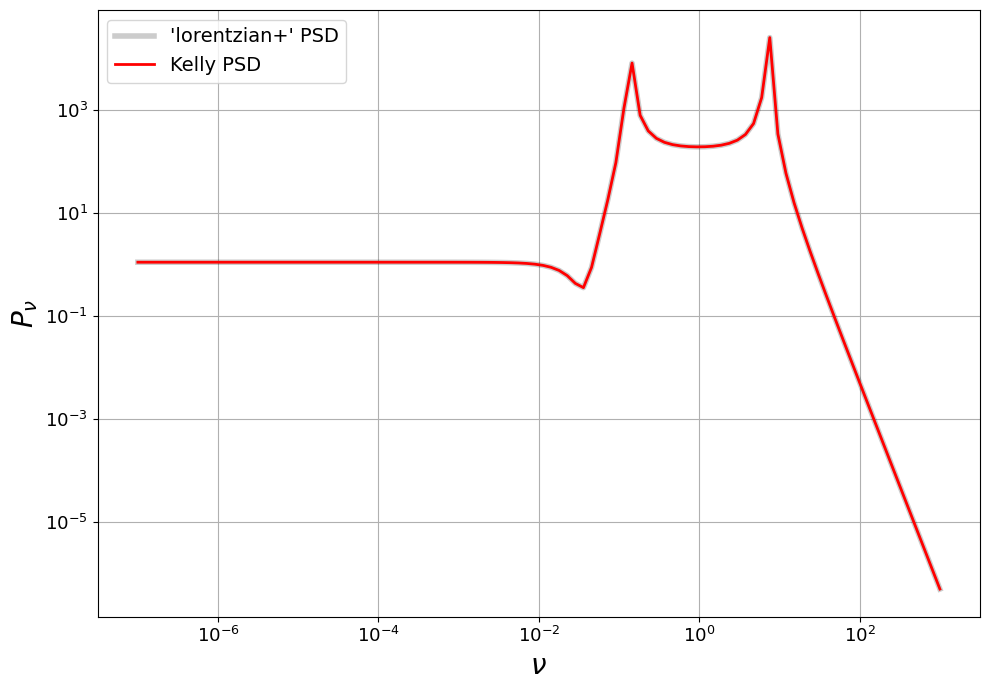

In [18]:
plt.figure(figsize=[10, 7])
plt.plot(freq, celeritePSD_lorentz, 'k-', lw=4, label = "'lorentzian+' PSD", alpha=0.2)
#plt.plot(freq, celeritePSD, 'r-', lw=3)

# sum = 0
# for i in range(len(true_lorentz)):
#     sum = sum + true_lorentz[i]
#     plt.plot(freq, true_lorentz[i], color='tab:blue' )

sum = 0
# color = ['g', 'b', 'purple', 'red']
# for i in range(len(pseudo_lorentz)):
#     #sum = sum + pseudo_lorentz[i]
#     x_pos, y_pos, x_neg, y_neg = separate_positive_negative_data(freq, pseudo_lorentz[i])
#     if len(y_pos)>0:
#         plt.plot(x_pos, y_pos, '--', color = 'b', lw = 3, alpha= 0.3, label = 'L'+str(i+1)+' pos')
#     if len(y_neg)>0:
#         plt.plot(x_neg, np.abs(y_neg), '-.', color = 'r', lw=3, alpha= 0.3, label = 'L'+str(i+1)+' neg')
    #plt.plot(freq, pseudo_lorentz[i], '--' )
plt.plot(freq, carmaPSD, 'r-', lw=2, label = 'Kelly PSD')

plt.legend(fontsize = 14)
#plt.plot(freq, sum, color = 'purple')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tick_params(labelsize=13)
plt.xlabel(r'$\nu$', fontsize=20)
plt.ylabel(r'$P_{\nu}$', fontsize=20)
plt.tight_layout()
#plt.savefig('plots/CARMA42_comp.png')

In [19]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod


def bend_pl_lorentz(f, norm, f_bend, alph_lo, alph_hi, sharpness, lor_rmssq, f_pk, q):
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=np.sqrt(lor_rmssq)/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    powmod_lorentz = ((1/np.pi)*2*r**2*q*f_res)/(f_res**2+(4*q**2*np.square(f-f_res)))
    
    powmod_bend_pl = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    
    return powmod_bend_pl+powmod_lorentz

In [32]:
alpha_beta_vals

{'log_alpha0': -3.0199148614762863,
 'log_alpha1': -3.0711102735081846,
 'log_alpha2': 0,
 'log_beta0': 0,
 'log_beta1': -6.992809136729863,
 'log_sigma': 0.0002267163389979976}

In [36]:
alpha_beta_vals =param_gen_alpha_beta(2,1, alpha_range=[-4,-3])
freq = np.fft.rfftfreq(2**21, d=0.01)[1:]   # [1:] to remove the DC power in the spectrum

spectrum_CARMA21 = CARMA_PSD_pq(alpha_beta_vals,freq)
alpha_beta_vals

{'log_alpha0': -3.242868041956709,
 'log_alpha1': -3.171553477612221,
 'log_beta1': 4.153920751279246,
 'log_sigma': 0.009202072165622069}

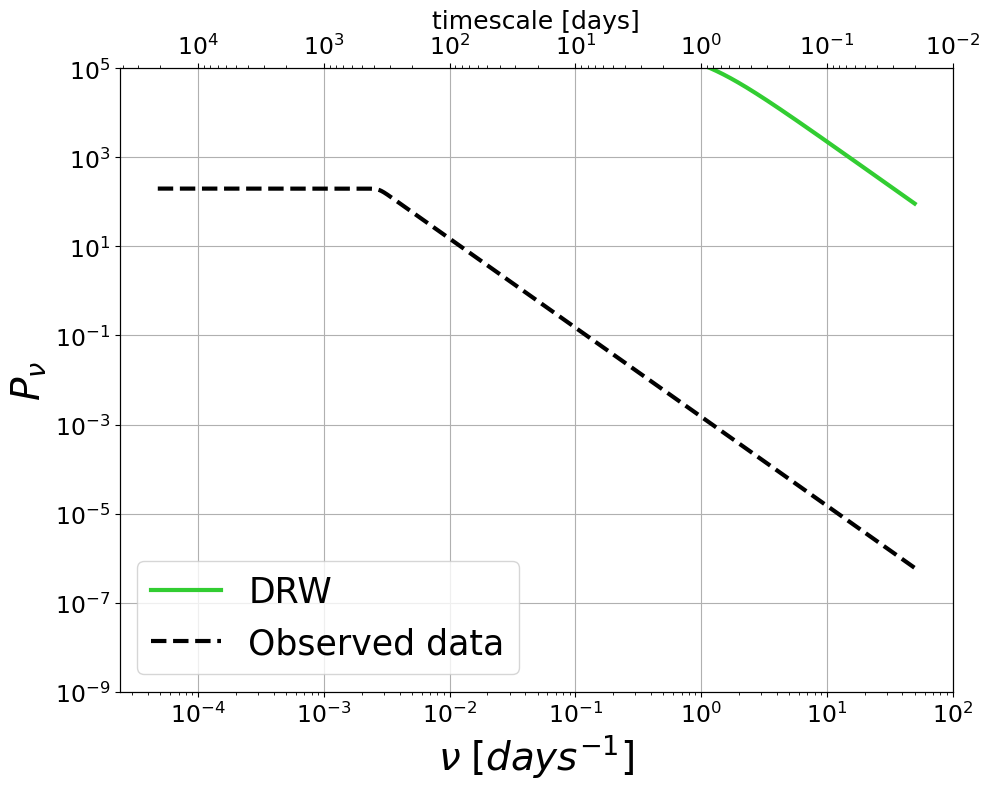

In [38]:
freq = np.fft.rfftfreq(2**21, d=0.01)[1:]   # [1:] to remove the DC power in the spectrum
spectrum_DRW = bend_pl(freq, 200,  1/365,  -0,-2,10)


spectrum_OBS1 = bend_pl(freq, 200,  1/365,  0,-2,10)


fig, ax = plt.subplots(1,1, figsize=[10,8])
#lc = self.sim.simulate(spectrum)
#plt.plot(lc.time/365, lc.counts, 'g')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_title('Power spectrum', fontsize=16)
ax.set_ylabel(r'$P_{\nu}$', fontsize=28)
ax.set_xlabel(r'$\nu\;[days^{-1}]$', fontsize=28)
ax.grid()
ax.set_ylim(bottom=10**-9 ,top = 10**5)
ax.tick_params(labelsize=17)
ax_top = ax.twiny()  
ax_top.set_xlabel('timescale [days]', fontsize = 18) 
ax_top.plot(1/freq, spectrum_DRW,'r-', lw=3, alpha=0.0)
ax_top.set_xscale('log')
ax_top.set_yscale('log')


ax.plot(freq, spectrum_CARMA21,'-', color= 'limegreen', lw=3, label='DRW')
ax.plot(freq, spectrum_OBS1,'k--', lw=3, label = 'Observed data')
#ax.plot(freq[freq<1/365], spectrum_OBS2,'k--', lw=3)

ax_top.tick_params(axis='x', labelsize=17)
ax_top.invert_xaxis()

ax.legend(fontsize=25)
plt.tight_layout()
# plt.savefig('plots/NAC/DRW_PSD_transparent.png', transparent = True)
plt.show()

In [ ]:
dt = 0.01
N = np.arange(0.01, 10, dt )
ACVF = CARMA_ACVF_pq(alpha_beta_vals, N)



f = np.fft.fftfreq(len(N), d=dt)
S = np.fft.fft(ACVF)

#plt.plot(f[0:len(f)//2+1], CARMA_PSD_pq(alpha_beta_vals,2*np.pi*f[0:len(f)//2+1]), 'k--')

plt.plot(np.abs(f), np.abs(S)**2, '-.')
plt.xscale('log')
plt.grid()
plt.yscale('log')


3420
roots of AR : [-2.89028660e-01+15.84358255j -2.89028660e-01-15.84358255j
  2.73001418e-04 +1.03377952j  2.73001418e-04 -1.03377952j]


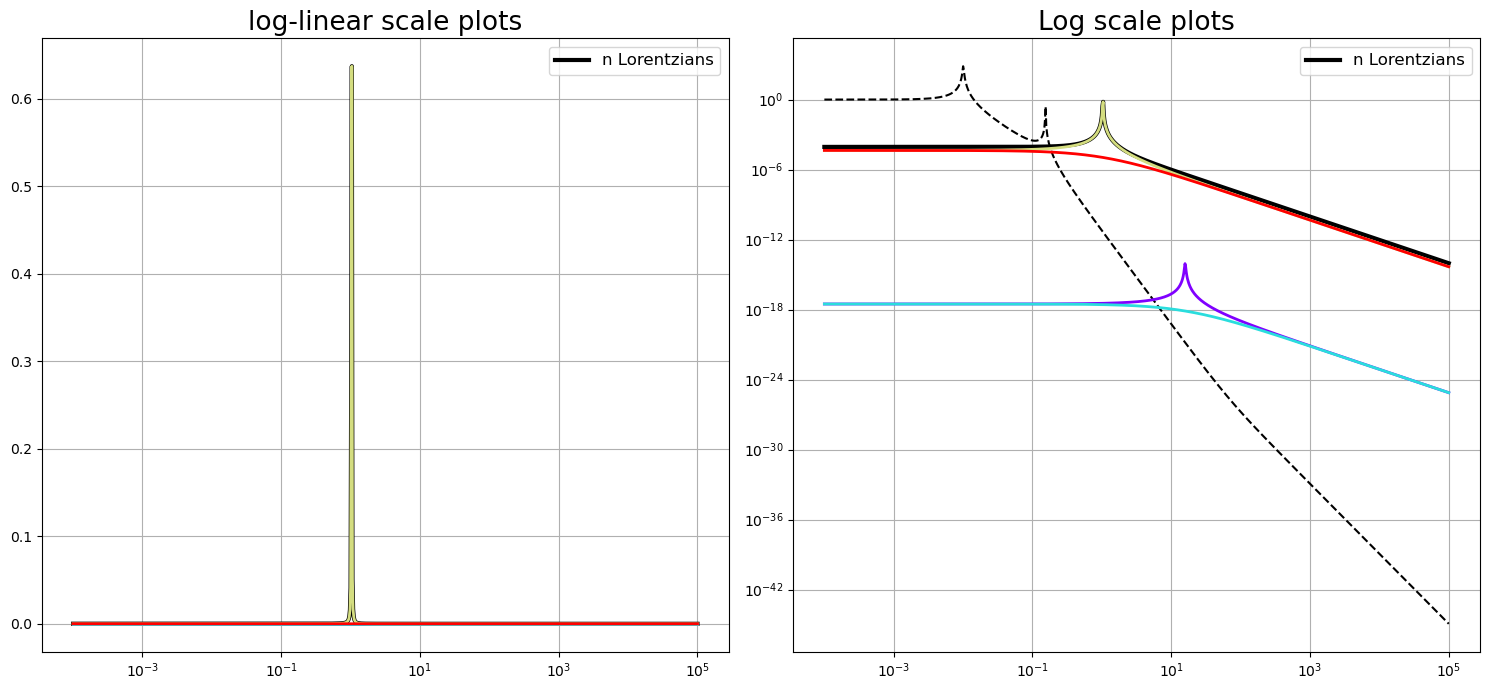

In [107]:
x_values = np.logspace(-4, 5, 1000)

rand =np.random.randint(10000)
print(rand)
np.random.seed(rand)

p,q = 4,1  # order of AR process or number of lorentzians
color = cm.rainbow(np.linspace(0, 1, p))

alpha_beta_vals = param_gen_alpha_beta(p,q)

params_list = CARMA2loretzian(alpha_beta_vals)
sum_of_lorentzians_values = sum_of_lorentzians(x_values, len(params_list), params_list)

# print the generated paramters
# for val in params_list:
#     print(val)


fig = plt.figure(figsize=[15,7])
fig.add_subplot(121)

plt.plot(x_values, sum_of_lorentzians_values, 'k-', lw=3, label = "n Lorentzians")

for i, val in enumerate(params_list):
    plt.plot(x_values, lorentzian(x_values, val), lw=2, alpha=1, color = color[i])
plt.xscale('log')
plt.gca().set_title("log-linear scale plots", fontsize=19)
plt.gca().grid(True)
plt.gca().legend(fontsize=12)



fig.add_subplot(122)
plt.plot(x_values, np.abs(sum_of_lorentzians_values), 'k-', lw=3, label = "n Lorentzians")
plt.plot(x_values, CARMA_PSD_pq(alpha_beta_vals, x_values), 'k--')

plt.grid(True)
for i, val in enumerate(params_list):
    plt.plot(x_values, lorentzian(x_values, val), lw=2, alpha=1, color = color[i])
plt.xscale('log')
plt.yscale('log')
plt.title("Log scale plots", fontsize=19)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
from scipy.optimize import least_squares

In [254]:
x_values = np.logspace(-4, 5, 1000)
x_data = np.log10(x_values)
y_data = np.log10(CARMA_PSD_pq(alpha_beta_vals, x_values))

def lorentzian(x, params):
    """
    Returns Lorentzian function at x.
    """
    center, width, amplitude = params
    return amplitude / (width**2 + ((x - center))**2)

def sum_of_lorentzians(x, n, params_list):
    """
    Returns sum of n Lorentzian functions.
    """
    result = np.zeros_like(x)
    for params in params_list[:]:
        result += lorentzian(x, params)
    return result

def log_lorentzian(x, params , n):
    
    return np.log10(sum_of_lorentzians(10**x, n, params))

def residual(params, x, y , n ):
    
    
    
    params_list = [[params[0], params[1], params[2]], 
                    [-params[0], params[1], params[2]]]
    
    # params_list = []
    # for i in range(len(params_list)//3):
    #     l = []
    #     for j in range(3):
    #         l.append(params[3*i + j])
    #     params_list.append(l)

    return y - log_lorentzian(x, params_list , n)




[[0.0011693972323985787, -0.0002781092466181449, 2.094665566310447e-07], [-0.0011693972323985787, -0.0002781092466181449, 2.094665566310447e-07]]


/tmp/ipykernel_83346/2360511364.py:23: RuntimeWarning: invalid value encountered in log10
  return np.log10(sum_of_lorentzians(10**x, n, params))


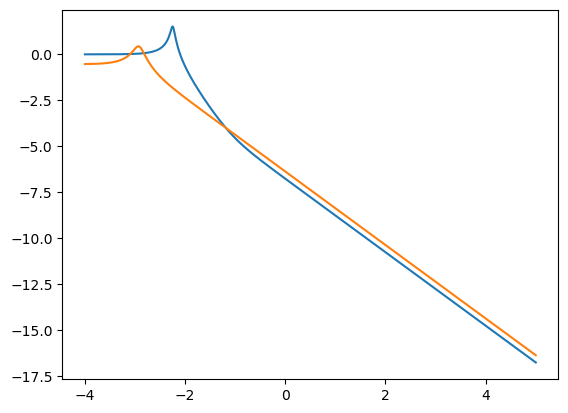

In [290]:
x_values = np.logspace(-4, 5, 1000)
alpha_beta_vals = param_gen_alpha_beta(2,1)
CARMA_PSD = CARMA_PSD_pq(alpha_beta_vals, x_values)

x_data = np.log10(x_values)
y_data = np.log10(CARMA_PSD_pq(alpha_beta_vals, x_values))

# real part, imag part, amplitude
# initial_guess = ([10, -10.0, 10.0, 10])
# result = least_squares(residual, initial_guess, args=(x_data, y_data , 2), 
#                                 method= 'trf', bounds=(  (0     , -np.inf, 0    , 0     ) ,
#                                                         (np.inf, 0      , np.inf, np.inf)))



# real part, imag part, amplitude
initial_guess = ([1, -10.0, 10.0])
result = least_squares(residual, initial_guess, args=(x_data, y_data , 2), 
                                method= 'lm')


params_list = [[result.x[0], result.x[1], result.x[2]], 
                    [-result.x[0], result.x[1], result.x[2]]]

print(params_list)
plt.plot(x_data, y_data)
plt.plot(x_data, log_lorentzian(x_data, params_list, 2))